In [203]:
# import all necessory libraries
import pandas as pd
import json as json
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import datetime as dt
import sys
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_style("darkgrid")
%matplotlib inline

# Part 1 - Exploratory Data Analysis

In [99]:
# load json data
json_file = 'logins.json'

data = pd.read_json(json_file)

In [100]:
#how much data
print(len(data['login_time']))

93142


In [101]:
#inspect keys
data.keys()

Index(['login_time'], dtype='object')

In [102]:
#check for na values
data['login_time'].isna().sum()

0

In [103]:
data.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## Aggregate logins counts based on 15-minute time intervals

In [104]:
#add count column for resample
data['count'] = 1
#set login time as index for resampling
data.index = data['login_time']
#drop redundant column
data.drop('login_time',axis=1,inplace=True)
data.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


In [110]:
# aggregate dates by 15min intervals
data_15T = data.resample('15T').sum()
data_15T.head(10)


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


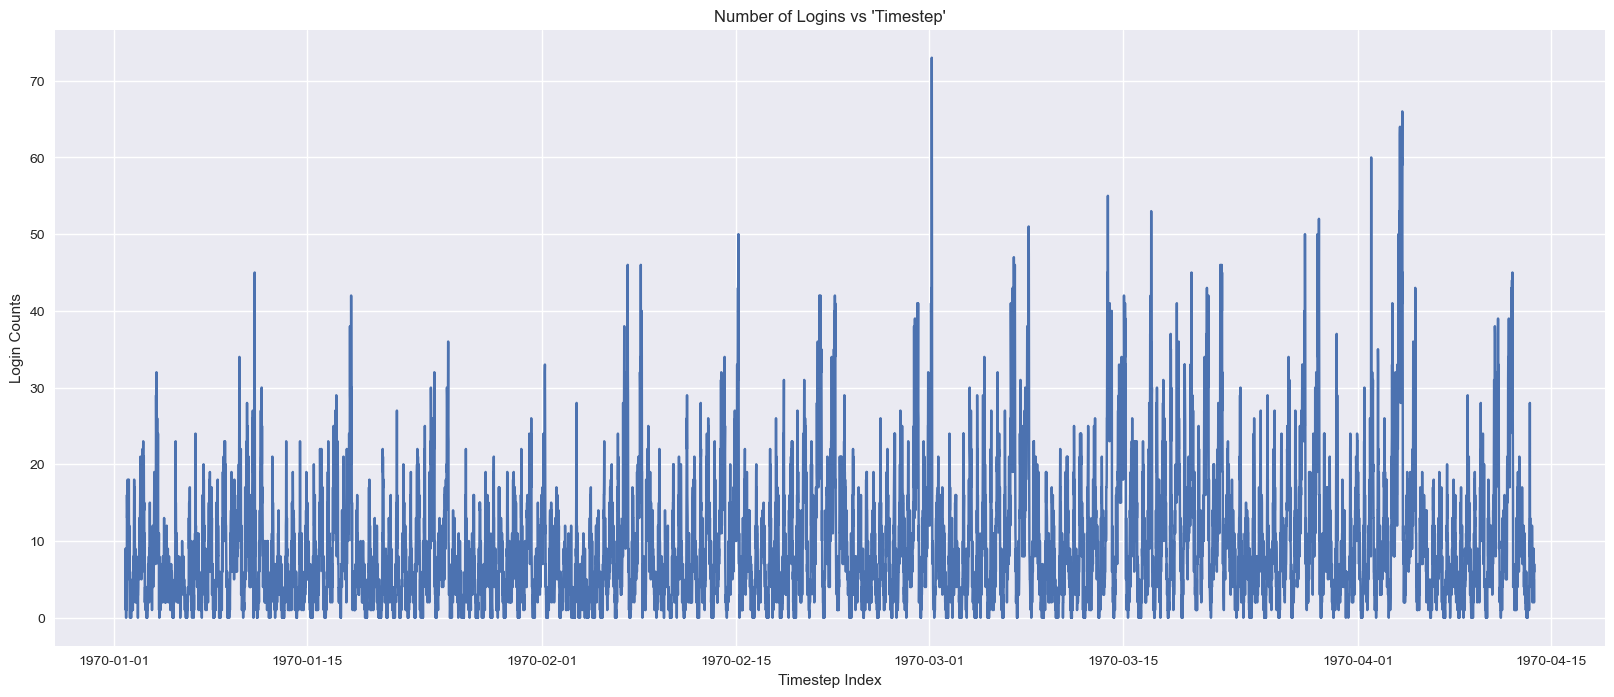

In [111]:
plt.figure(figsize=(20,8))
plt.plot(data_15T)
plt.title("Number of Logins vs 'Timestep'")
plt.xlabel("Timestep Index")
plt.ylabel("Login Counts")
plt.show()

Plotting the 15 minute intervals over the 4 month period, we can see a sinusoidal pattern that seems to have an average value that is increasing.



In [112]:
# reset index 
df = data.reset_index()
data_15T = data_15T.reset_index()

In [113]:
# create new columns of date, hour and weekday
df['date'] = df['login_time'].apply(lambda date: dt.date(date.year, date.month, date.day))
df['hour'] = df['login_time'].apply(lambda h: h.hour)
df['weekday'] = df['login_time'].apply(lambda w: w.weekday())


In [114]:
df.head(10)

,login_time,count,date,hour,weekday
0,1970-01-01 20:13:18,1,1970-01-01,20,3
1,1970-01-01 20:16:10,1,1970-01-01,20,3
2,1970-01-01 20:16:37,1,1970-01-01,20,3
3,1970-01-01 20:16:36,1,1970-01-01,20,3
4,1970-01-01 20:26:21,1,1970-01-01,20,3
5,1970-01-01 20:21:41,1,1970-01-01,20,3
6,1970-01-01 20:12:16,1,1970-01-01,20,3
7,1970-01-01 20:35:47,1,1970-01-01,20,3
8,1970-01-01 20:35:38,1,1970-01-01,20,3
9,1970-01-01 20:47:52,1,1970-01-01,20,3


In [115]:
# count daily total logins and sort by date
by_date = df['date'].value_counts().sort_index()
by_date.head()

1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459
Name: date, dtype: int64

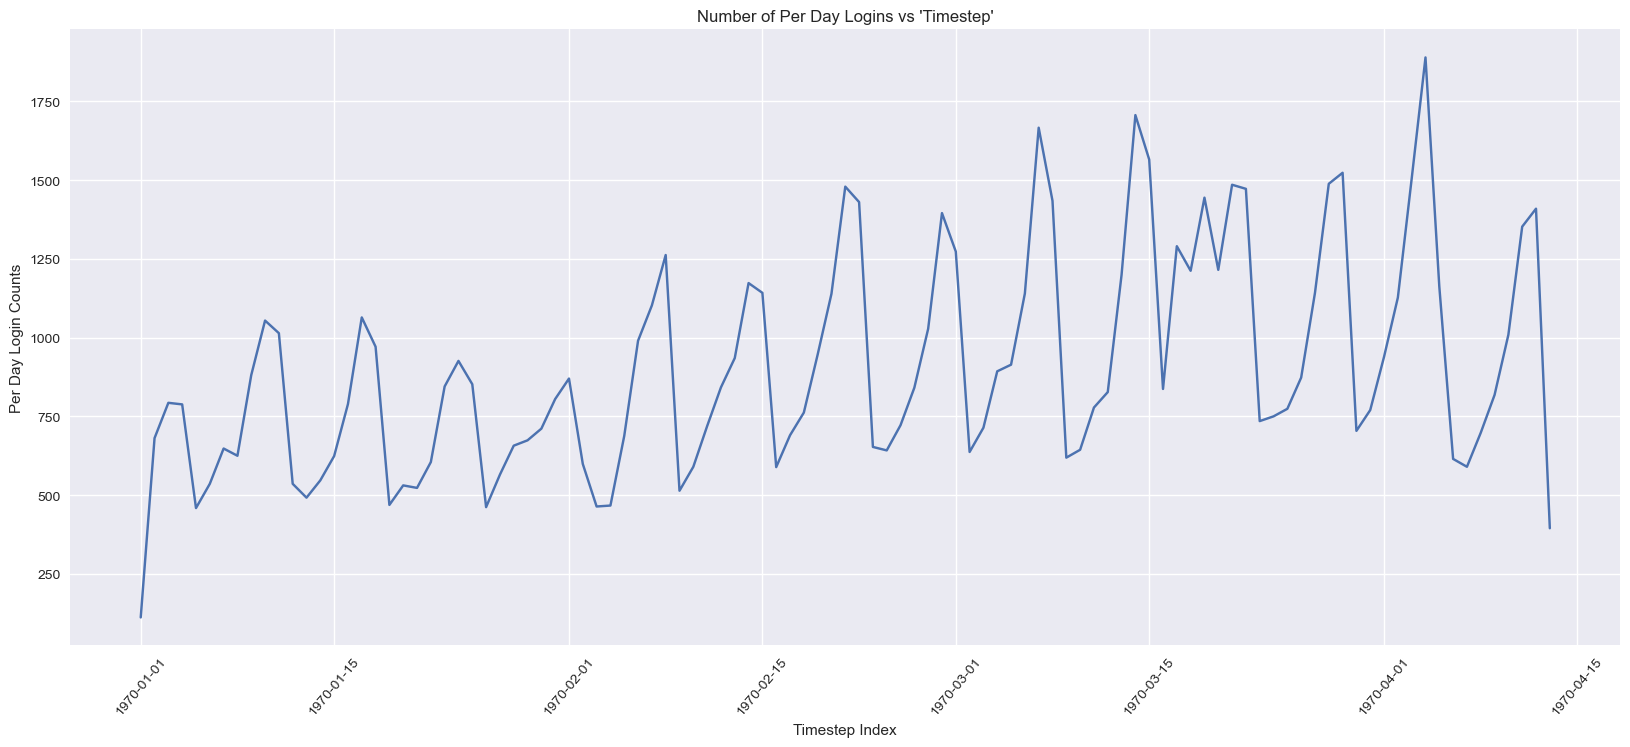

In [116]:
# plot daily login counts
plt.figure(figsize=(20,8))
plt.plot(by_date)
plt.title("Number of Per Day Logins vs 'Timestep'")
plt.xlabel("Timestep Index")
plt.xticks(rotation = 50)
plt.ylabel("Per Day Login Counts")
plt.show()

Resampling to daily frequency shows there is an increasing trend of the average number of logins. At first, through the month of January, there seems to be little or no change in the average number of daily logins, then February starts the increasing trend. Linear model plots will confirm or deny this.

## Check Monthly Total Logins

In [117]:
login_months = data_15T.groupby(data_15T['login_time'].dt.strftime('%B'))['count'].sum().sort_values(ascending=False)
login_months

login_time
March       33723
February    24673
January     21239
April       13507
Name: count, dtype: int64

- As above, it seems March has more logins than all other months
- April month has least amount of logins. Need to look into systems to see if the dip in April is caused by any data/system issue.

## Logins by Weekday

In [119]:
# Counttotal logins by each weekday Monday (index = 0) to Sunday (index = 6)
data_15T['weekday'] = data_15T['login_time'].dt.dayofweek
data_weekday = data_15T.sort_values(by='count', ascending=False)
weekday_login_counts = data_weekday[['count', 'weekday']]
weekday_login_counts = weekday_login_counts.groupby('weekday').sum().reset_index()
weekday_login_counts

,weekday,count
0,0,8823
1,1,9268
2,2,10339
3,3,11960
4,4,15208
5,5,19377
6,6,18167


In [122]:
# Replace weekday numeric values to name of week day
weekday_login_counts['weekday'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
weekday_login_counts = weekday_login_counts[['weekday','count']]
weekday_login_counts

,weekday,count
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


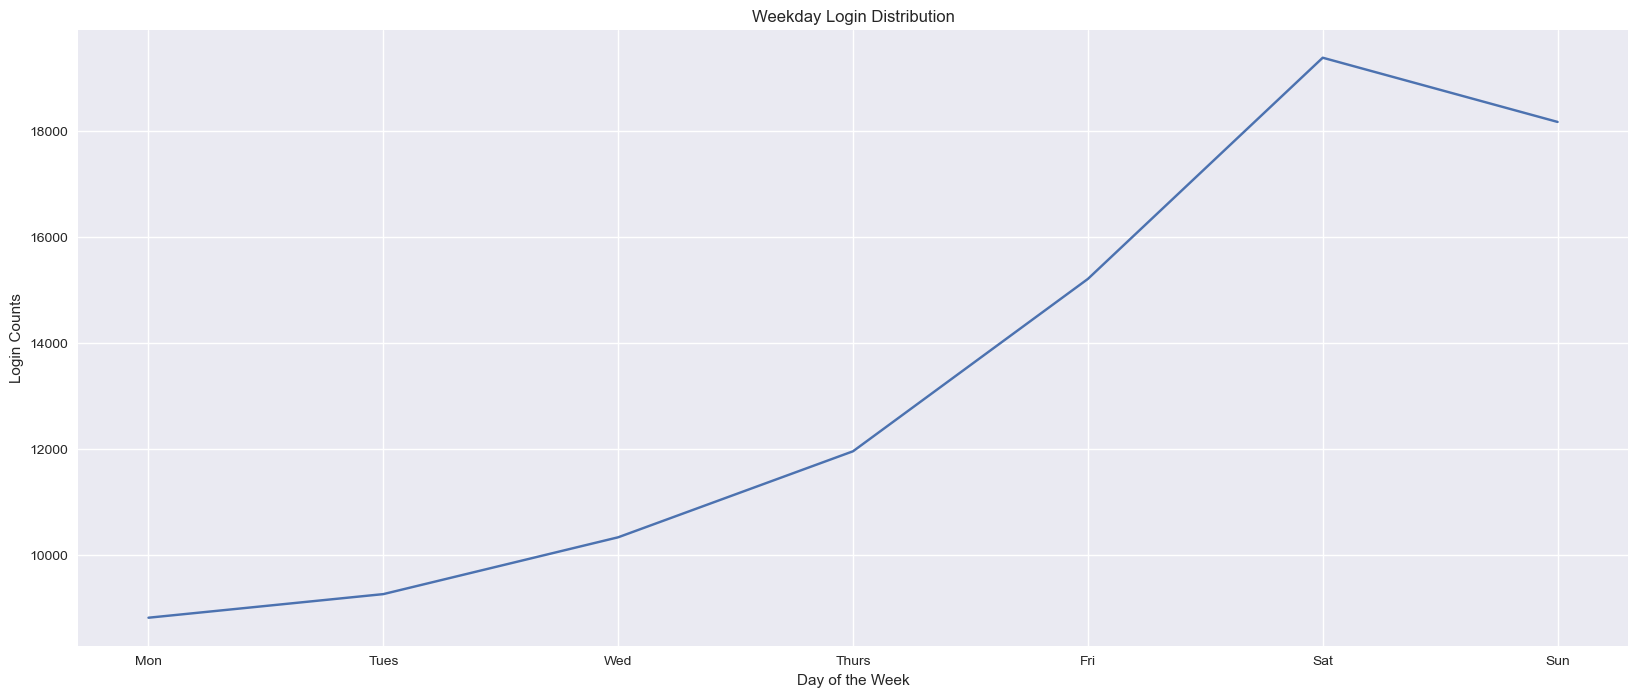

In [123]:
# plot total logins by each week day
plt.figure(figsize=(20,8))
sns.lineplot(x= 'weekday', y='count', data=weekday_login_counts)
plt.xlabel('Day of the Week')
plt.title('Weekday Login Distribution')
plt.ylabel('Login Counts')
plt.show()

- As days going from monday to sunday, Number of logins are increasing gradually.
- Most logins occur in weekends.
- Comparing to other days of week, saturday has maximum number of logins.

## Logins by Hour

In [124]:
# Counting based on weekdays, 0 = Monday, 6 = Sunday
data_15T['hour'] = data_15T['login_time'].dt.hour
data_hour = data_15T.sort_values(by='count', ascending=False)
hour_login_counts = data_hour[['count', 'hour']]
hour_login_counts = data_hour.groupby('hour').sum().reset_index()
hour_login_counts.head()

,hour,count,weekday
0,0,5993,1236
1,1,6317,1236
2,2,5800,1236
3,3,4831,1236
4,4,5034,1236


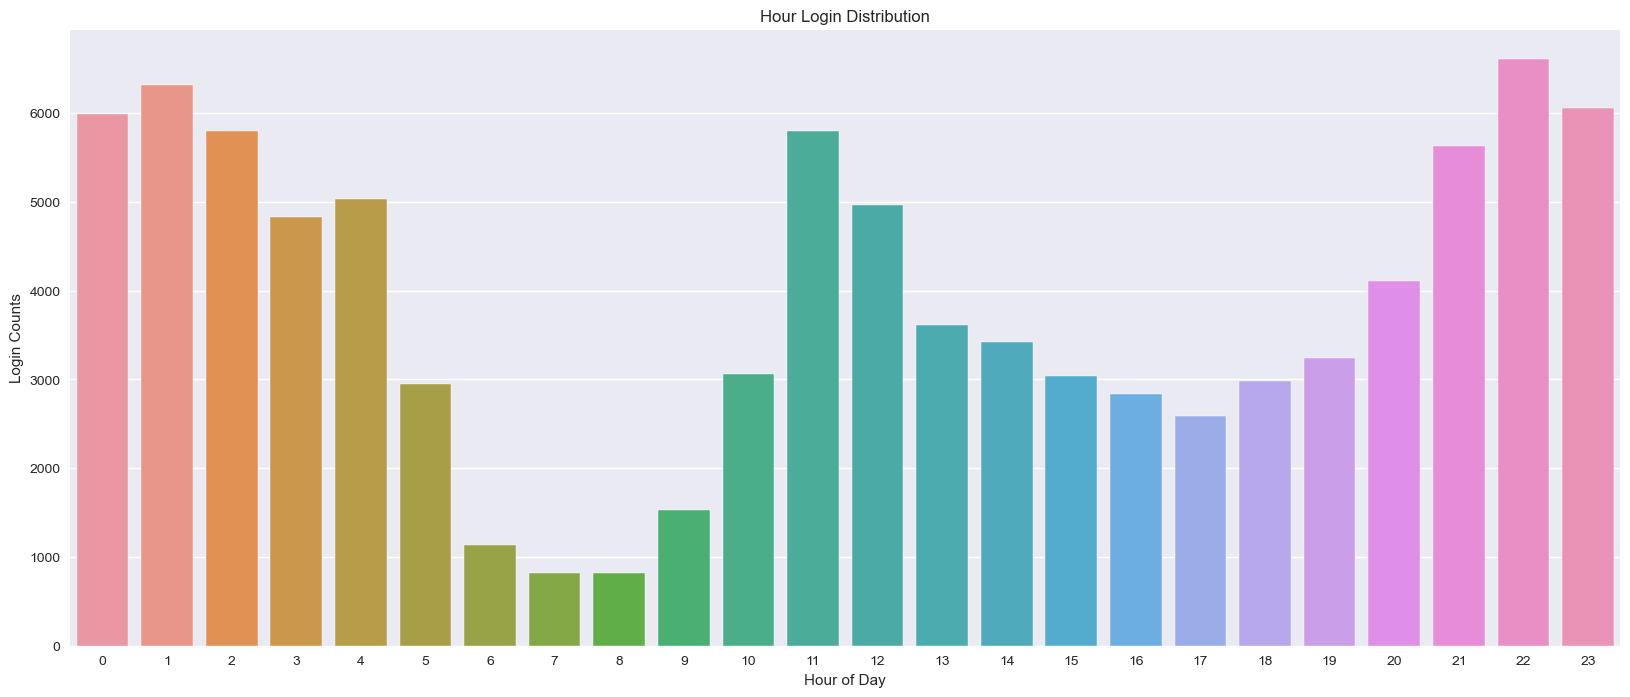

In [126]:
# plot total logins by each hour 
plt.figure(figsize=(20,8))
sns.barplot(x= 'hour', y='count', data=hour_login_counts)
plt.xlabel('Hour of Day')
plt.title('Hour Login Distribution')
plt.ylabel('Login Counts')
plt.show()

- The peak hours for the app: 10 pm - 1 am 
- off-peak hours: 6 am - 9 am

### Also consider: What Geo Location could the data be collected?
The location might be a dynamic neighborhood full of entertainment, restaurants and nightlife

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success of this experiment in encouraging driver partners to serve both cities could be the number of cross-city trips taken by the driver partners. This metric would provide an accurate indication of whether the reimbursement of toll costs has encouraged the driver partners to serve both cities. An increase in the number of cross-city trips would indicate that the driver partners are taking advantage of the toll reimbursement and serving both cities more often.

Additionally, the revenue generated from cross-city trips can also be considered as a secondary metric. An increase in revenue from cross-city trips would indicate that the reimbursement of toll costs has led to an increase in demand for such trips, which would be a positive outcome for the experiment.

Overall, these metrics would help the Ultimate managers of city operations to determine the effectiveness of the toll reimbursement policy in encouraging driver partners to serve both cities, which would be essential in making any future decisions regarding the policy.

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

**a. how you will implement the experiment**

**b. what statistical test(s) you will conduct to verify the significance of the observation**

**c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.**


**a) Experiment Design:**
To compare the effectiveness of the proposed toll reimbursement policy, I would design a randomized controlled experiment that involves a sample of driver partners. The experiment would be conducted over a period of three months, with the first month serving as a control period where no toll reimbursement policy is implemented, and the next two months implementing the toll reimbursement policy.

During the control period, data would be collected on the number of cross-city trips taken by the driver partners, as well as the revenue generated from these trips. This data would serve as a baseline for comparison with the subsequent two months when the toll reimbursement policy is implemented.

For the next two months, the driver partners in the sample would be notified of the toll reimbursement policy and would be reimbursed for all toll costs incurred while crossing the bridge. Data would be collected during this period on the number of cross-city trips taken by the driver partners, as well as the revenue generated from these trips.

**b) Statistical Tests:**
To verify the significance of the observation, I would conduct a t-test to compare the means of the number of cross-city trips and the revenue generated during the control period and the two-month period when the toll reimbursement policy is implemented. The t-test would be used to determine if there is a significant difference between the means of the two groups, and whether this difference is statistically significant.

**c) Interpreting Results and Recommendations:**
If the results of the t-test indicate a statistically significant increase in the number of cross-city trips and revenue generated during the two-month period when the toll reimbursement policy is implemented, it can be concluded that the policy is effective in encouraging driver partners to serve both cities.

Based on these results, I would recommend that the city operations team continue with the toll reimbursement policy, and consider expanding the policy to include other incentives such as bonuses for cross-city trips or reduced licensing fees for driver partners who frequently serve both cities.

However, it is essential to note that there may be other factors that could influence the results, such as changes in demand for cross-city trips during the experimental period, changes in weather conditions, or changes in traffic flow patterns. Therefore, any recommendations should be made with these caveats in mind, and future experiments may be necessary to confirm the findings.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

### Data Description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [130]:
# load json data
json_file = 'ultimate_data_challenge.json'

df = pd.read_json(json_file)

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [166]:
df.signup_date=pd.to_datetime(df.signup_date)
df.last_trip_date=pd.to_datetime(df.last_trip_date)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49596 non-null  object        
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [167]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49992.000000,49992.000000,49992.000000,49992.000000,49992.000000,49992.00000,49992.000000
mean,2.278405,4.601519,1.074776,8.850952,60.929833,5.79726,4.778123
std,3.792953,0.565008,0.222352,19.960094,37.078229,5.70761,0.445780
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.42000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.88000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.94000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.96000,5.000000


#### Check for null values

In [134]:
df.isnull().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

In [138]:
# Replace null with mean 
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

#### Check for duplicate 

In [161]:
# Check for duplicate
duplicates = df.duplicated()

# print the boolean mask
print(duplicates.sum())

8


In [162]:
# remove duplicates
df = df.drop_duplicates()

In [164]:
# Check for duplicate
duplicates = df.duplicated()

# print the boolean mask
print(duplicates.sum())

0


User consider as retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [174]:
# Check last trip date
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [175]:
# Adding a retained label and set values to 0
df["Retained"] = 0
# Active users will have a value of 1 if they were active within the past 30 days
df.loc[df['last_trip_date'] >= "2014-06-01", "Retained"] = 1

In [177]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


### EDA

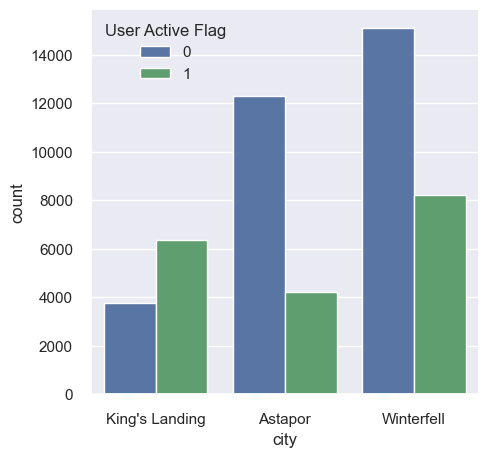

In [196]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(x=df.city, hue=df.Retained)
ax.legend(title='User Active Flag', loc='best') # update the legend title
plt.show()

Users who signed up in King's landing are more likely to be retained.

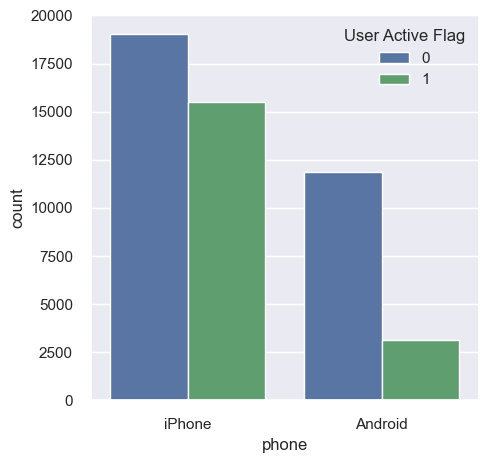

In [195]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(x=df.phone, hue=df.Retained)
ax.legend(title='User Active Flag', loc='best') # update the legend title
plt.show()

Android users are less likely to be active users after 6 months.

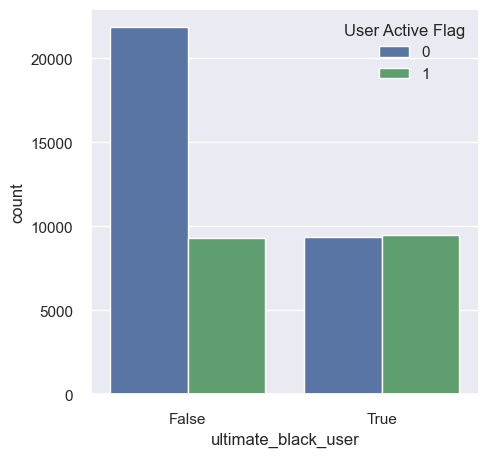

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(x=df.ultimate_black_user, hue=df.Retained)
ax.legend(title='User Active Flag', loc='best') # update the legend title
plt.show()

Users who did not take an Ultimate Black in their first 30 days are less likely to be retained users.

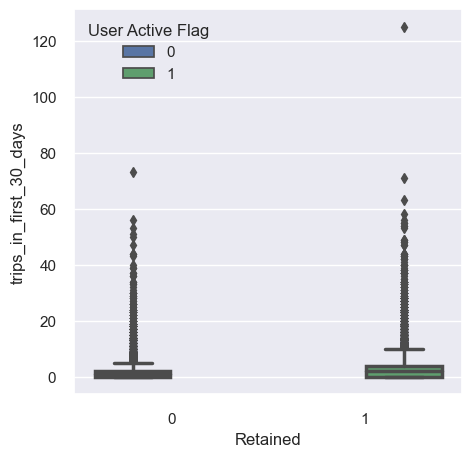

In [192]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.boxplot(x=df.Retained, y=df.trips_in_first_30_days, hue=df.Retained)
ax.legend(title='User Active Flag', loc='best') # update the legend title
plt.show()

Active users took slightly more trips in their first 30 days.

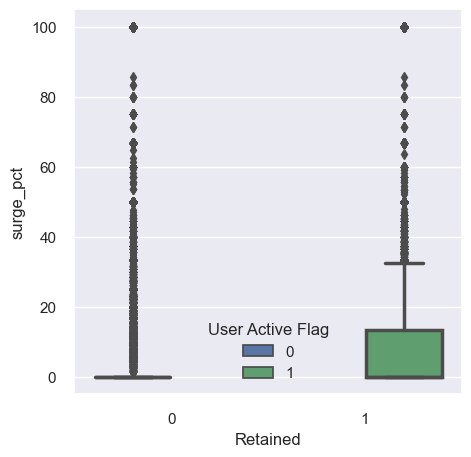

In [197]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.boxplot(x=df.Retained, y=df.surge_pct, hue=df.Retained)
ax.legend(title='User Active Flag', loc='best') # update the legend title
plt.show()

Active users have taken more of the trips with surge multiplier compared with
inactive users.

In [180]:
corr_data = df.corr()
corr_data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Retained
trips_in_first_30_days,1.000000,-0.011036,-0.001859,0.005696,0.112220,0.050363,-0.136360,-0.039072,0.210433
avg_rating_of_driver,-0.011036,1.000000,-0.021630,-0.003259,-0.001920,0.012629,0.028544,0.101630,-0.010775
avg_surge,-0.001859,-0.021630,1.000000,0.793578,-0.078798,-0.110124,-0.081521,0.010525,-0.003375
surge_pct,0.005696,-0.003259,0.793578,1.000000,-0.106871,-0.144990,-0.104453,0.020000,0.011742
ultimate_black_user,0.112220,-0.001920,-0.078798,-0.106871,1.000000,0.036132,0.032308,0.009330,0.205028
weekday_pct,0.050363,0.012629,-0.110124,-0.144990,0.036132,1.000000,0.101607,0.020420,0.009617
avg_dist,-0.136360,0.028544,-0.081521,-0.104453,0.032308,0.101607,1.000000,0.079835,-0.092847
avg_rating_by_driver,-0.039072,0.101630,0.010525,0.020000,0.009330,0.020420,0.079835,1.000000,-0.026688
Retained,0.210433,-0.010775,-0.003375,0.011742,0.205028,0.009617,-0.092847,-0.026688,1.000000


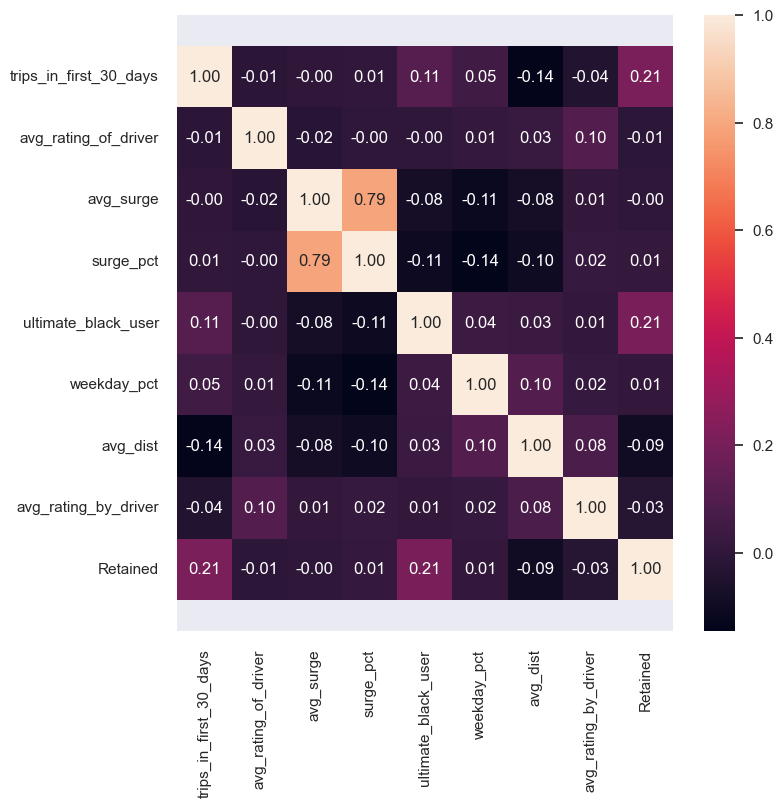

In [212]:
# plot heatmap to visualize correlation of numeric features
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
ax = sns.heatmap(corr_data, annot = True, fmt = ".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

As above heatmap, surge_pct and avg_surge features have strong correlation with each other.

### Pre Processing

In [ ]:
df.ultimate_black_user = df.ultimate_black_user.astype(object)

In [ ]:
# Drop last_trip_date and signup_date because it won't useful with model
df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49992 non-null  object 
 1   trips_in_first_30_days  49992 non-null  int64  
 2   avg_rating_of_driver    49992 non-null  float64
 3   avg_surge               49992 non-null  float64
 4   phone                   49596 non-null  object 
 5   surge_pct               49992 non-null  float64
 6   ultimate_black_user     49992 non-null  object 
 7   weekday_pct             49992 non-null  float64
 8   avg_dist                49992 non-null  float64
 9   avg_rating_by_driver    49992 non-null  float64
 10  Retained                49992 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 4.6+ MB


#### Differentiate numerical features (minus the target) and categorical features

In [241]:
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Retained")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 7
Categorical features : 3


In [217]:
# convert all categorical features to numeric 
ohe_df = pd.get_dummies(df, drop_first=True)
ohe_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,Retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,0,0


In [219]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trips_in_first_30_days    49992 non-null  int64  
 1   avg_rating_of_driver      49992 non-null  float64
 2   avg_surge                 49992 non-null  float64
 3   surge_pct                 49992 non-null  float64
 4   weekday_pct               49992 non-null  float64
 5   avg_dist                  49992 non-null  float64
 6   avg_rating_by_driver      49992 non-null  float64
 7   Retained                  49992 non-null  int64  
 8   city_King's Landing       49992 non-null  uint8  
 9   city_Winterfell           49992 non-null  uint8  
 10  phone_iPhone              49992 non-null  uint8  
 11  ultimate_black_user_True  49992 non-null  uint8  
dtypes: float64(6), int64(2), uint8(4)
memory usage: 3.6 MB


In [242]:
train_num

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.700000,1.10,15.4,46.2,3.67,5.0
1,0,5.000000,1.00,0.0,50.0,8.26,5.0
2,3,4.300000,1.00,0.0,100.0,0.77,5.0
3,9,4.600000,1.14,20.0,80.0,2.36,4.9
4,14,4.400000,1.19,11.8,82.4,3.13,4.9
...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2
49996,1,4.601559,1.00,0.0,0.0,0.00,4.0
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5


In [243]:
train_cat

,city,phone,ultimate_black_user
0,King's Landing,iPhone,True
1,Astapor,Android,False
2,Astapor,iPhone,False
3,King's Landing,iPhone,True
4,Winterfell,Android,False
...,...,...,...
49995,King's Landing,iPhone,False
49996,Astapor,iPhone,False
49997,Winterfell,Android,True
49998,Astapor,iPhone,False


#### Log transform of the skewed numerical features to lessen impact of outliers

In [244]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

6 skewed numerical features to log transform


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_44574/3352021519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num[skewed_features] = np.log1p(train_num[skewed_features])


In [236]:
train_cat

,city,phone,ultimate_black_user
0,King's Landing,iPhone,True
1,Astapor,Android,False
2,Astapor,iPhone,False
3,King's Landing,iPhone,True
4,Winterfell,Android,False
...,...,...,...
49995,King's Landing,iPhone,False
49996,Astapor,iPhone,False
49997,Winterfell,Android,True
49998,Astapor,iPhone,False


In [245]:
train_num

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,1.609438,1.740466,0.741937,2.797281,46.2,1.541159,1.791759
1,0.000000,1.791759,0.693147,0.000000,50.0,2.225704,1.791759
2,1.386294,1.667707,0.693147,0.000000,100.0,0.570980,1.791759
3,2.302585,1.722767,0.760806,3.044522,80.0,1.211941,1.774952
4,2.708050,1.686399,0.783902,2.549445,82.4,1.418277,1.774952
...,...,...,...,...,...,...,...
49995,0.000000,1.791759,0.693147,0.000000,100.0,1.891605,1.648659
49996,0.693147,1.723045,0.693147,0.000000,0.0,0.000000,1.609438
49997,0.000000,1.791759,0.693147,0.000000,100.0,1.581038,1.791759
49998,1.098612,1.386294,0.693147,0.000000,100.0,1.719189,1.504077


#### One HotEncoding

In [246]:
# convert all categorical features to numeric 
train_cat = pd.get_dummies(train_cat, drop_first=True)
train_cat.head()

,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,1,0,1,1
1,0,0,0,0
2,0,0,1,0
3,1,0,1,1
4,0,1,0,0


In [ ]:
df.ultimate_black_user = df.ultimate_black_user.astype(object)

### Modeling - Classification

In [281]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time

#### Split into testing and training datasets

In [253]:
# Join categorical and numerical features
X = pd.concat([train_num, train_cat], axis = 1)
y = df.Retained
print("New number of features : " + str(df.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 11
X_train : (39993, 11)
X_test : (9999, 11)
y_train : (39993,)
y_test : (9999,)


#### Standardize the magnitude of numeric features using a scaler

In [255]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

### Logistic Regression
Logistic Regression is more interpretable as it gives insights on the weight of each feature on the
user retention probability.

In [299]:
# Instantiate the logistic regression model
lg = LogisticRegression()

# Fit the model on the training data
lg.fit(X_train, y_train)

# Predict on the testing data
y_pred = lg.predict(X_test)

cv_scores = cross_val_score(lg, X_train.values, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.72584073 0.72846606 0.727966   0.72468117 0.7251813 ]
Average 5-Fold CV Score: 0.7264270499428833


In [304]:
# Evaluate the performance of the classifier
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      6201
           1       0.69      0.51      0.59      3798

    accuracy                           0.73      9999
   macro avg       0.72      0.69      0.69      9999
weighted avg       0.72      0.73      0.72      9999

Test set accuracy: 72.90%


ROC AUC: 0.7756


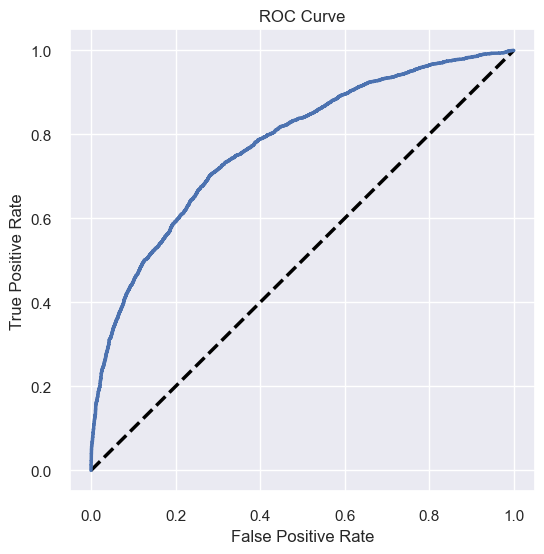

In [305]:
# Compute predicted probabilities
y_pred_prob = lg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Compute and print AUC score
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

#### Mode Performance

- The model has a good accuracy score & ROC AUC score since the data has unbalanced classes
- The reacll score looks low which means the model will have problem capturing real active users that are likely to be retained

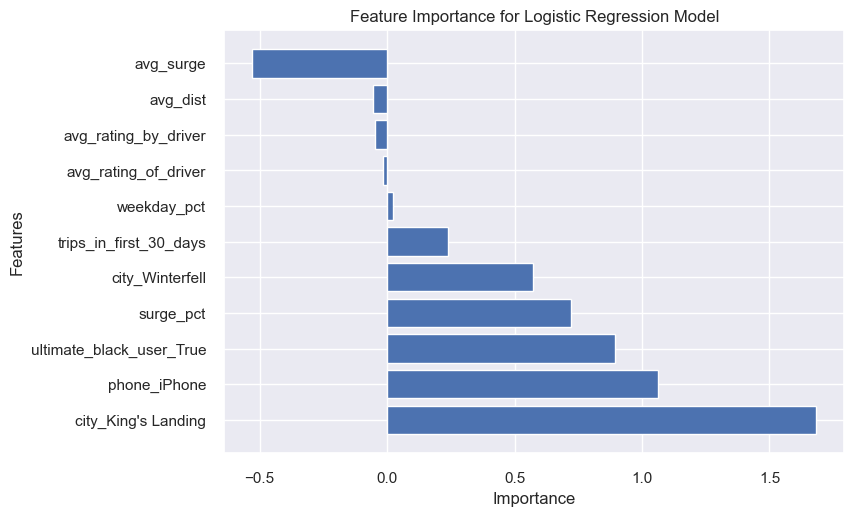

In [301]:
# Get the feature importance
coef = lg.coef_[0]
importance = coef

# Sort the features by importance in descending order
indices = importance.argsort()[::-1]
features = X_train.columns[indices]

# Plot the feature importance
plt.barh(range(len(X_train.columns)), importance[indices])
plt.yticks(range(len(X_train.columns)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Logistic Regression Model')
plt.show()

- Top positive features: “King’s landing” signup place, “Ultimate Black” usage and iPhone user device
- “King’s landing” signup place, “Ultimate Black” usage and iPhone user device

### Random Forest
Random Forest Classifier is less interpretable but it gives more accurate predictions, avoids overfitting and also provides insights on feature importance.

In [257]:
clf = RandomForestClassifier()

In [258]:
cv_scores = cross_val_score(clf, X_train.values, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.75321915 0.75646956 0.76234529 0.76456614 0.74731183]
Average 5-Fold CV Score: 0.7567823947485808


#### Random Forest - Hyperparameter Tuning using GridSearchCV

Using GridSearchCV as the parameter space is relatively small (less than 5) and the search can be performed in a reasonable amount of time. 

In [259]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [261]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [262]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.784987320714414


In [265]:
rfc_best = RandomForestClassifier(**grid_search.best_params_)
rfc_best.fit(X_train, y_train)

y_pred = rfc_best.predict(X_test)

# Evaluate the performance of the classifier
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6201
           1       0.75      0.64      0.69      3798

    accuracy                           0.78      9999
   macro avg       0.78      0.76      0.76      9999
weighted avg       0.78      0.78      0.78      9999

Test set accuracy: 78.48%


AUC: 0.8534


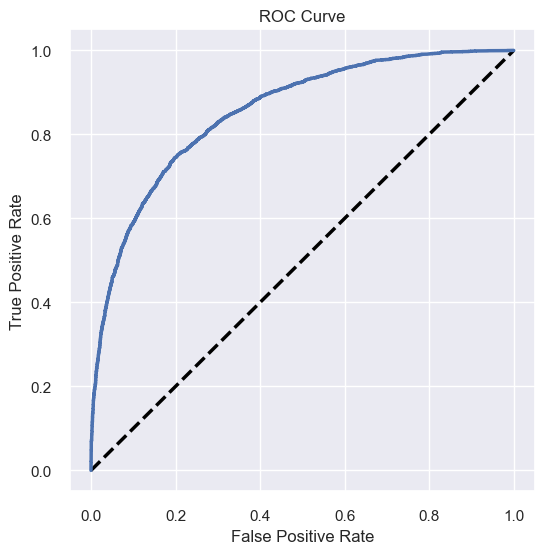

In [306]:
# Compute predicted probabilities
y_pred_prob = rfc_best.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

#### Mode Performance

- Randome Forest classifier performs better than logistic regression model with 78.48% test set accuracy and 0.85 ROC AUC score

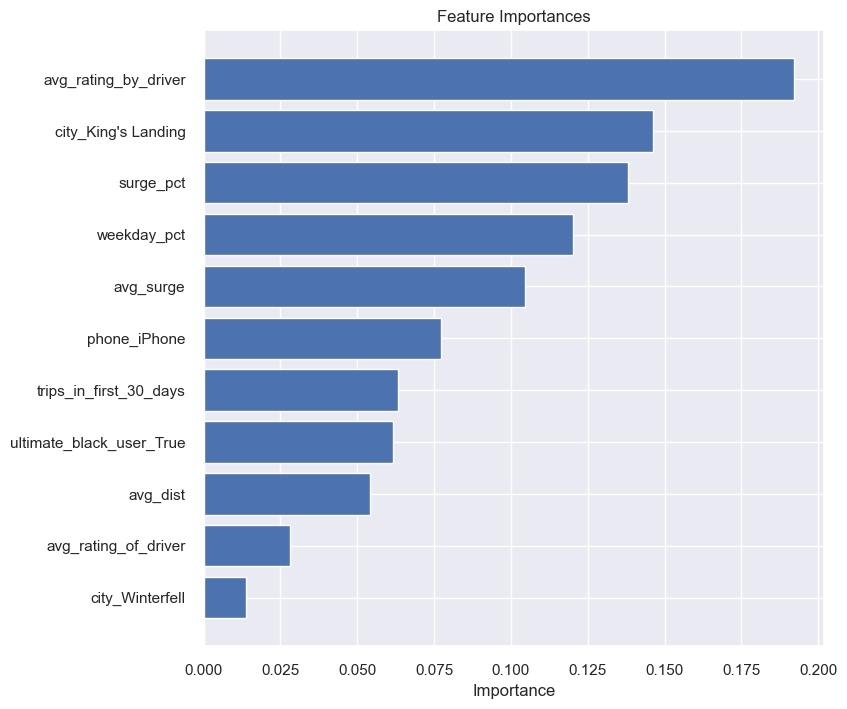

In [280]:
import matplotlib.pyplot as plt

# Get the feature importances
importances = rfc_best.feature_importances_

# Get the names of the features
features = X.columns

# Sort the feature importances in descending order
indices = importances.argsort()[::1]

# Sort the feature names according to their importance
sorted_features = [features[i] for i in indices]

# Create a bar chart to visualize the feature importances
plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), sorted_features)
plt.xlabel("Importance")
plt.show()


Top positive features:
- Average rating by driver, city_King's Landing, surge_pct

### Business Insights & Recommendation

- Use the retention probability to score the new users: promote referral program towards high- quality users & reduce initial acquisition cost on low-quality users

- Spend more marketing budget for targeting at iPhone users at King’s Landing for marketing acquisition.

- Research on UI experience of the Android app

- Experiment on promotions to motivate users to use more of the app during their first 30 day trial

- Research on the pricing and user experience of surge multiplier function for long-term user retention